In [1]:
# pip install pandas
# pip install scikit-learn
# pip install torchtext
# pip install gensim

import pandas as pd
from sklearn.model_selection import train_test_split
import re

In [2]:
INPUT_PATH = './spam.csv'
df = pd.read_csv(INPUT_PATH, encoding='latin-1')[['v1', 'v2']]
df['target'] = (df['v1'] == 'spam').astype(int)
df['v2'] = df['v2'].apply(lambda w : w.lower())
df['v2'] = df['v2'].apply(lambda w : re.sub(r'[^a-z]+', ' ', w))
df

v1                                                 v2  target
0      ham  go until jurong point crazy available only in ...       0
1      ham                           ok lar joking wif u oni        0
2     spam  free entry in a wkly comp to win fa cup final ...       1
3      ham       u dun say so early hor u c already then say        0
4      ham  nah i don t think he goes to usf he lives arou...       0
...    ...                                                ...     ...
5567  spam  this is the nd time we have tried contact u u ...       1
5568   ham                 will b going to esplanade fr home        0
5569   ham  pity was in mood for that so any other suggest...       0
5570   ham  the guy did some bitching but i acted like i d...       0
5571   ham                          rofl its true to its name       0

[5572 rows x 3 columns]

In [3]:
from torchtext.data.utils import get_tokenizer
from gensim.models import KeyedVectors

# gensim is a popular NLP library
"""
    需要科学上网
    或参考https://www.zhihu.com/question/24929678，先把模型下载到本地，再load

    通过网盘分享的文件：gensim-data
    链接: https://pan.baidu.com/s/163dZMXMo7qMdpqzHtJjCjA 提取码: 6hfw
"""
model_path = 'gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz'

# Get the tokenizer
tokenizer = get_tokenizer("basic_english")
word2vec_model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [4]:
def pre_processing(sentence, tokenizer, word2vec_model):
    tokens = tokenizer(sentence)
    embeddings = [word2vec_model[token] for token in tokens if token in word2vec_model]
    if len(embeddings) == 0:
        print(f'No embeddings found for sentence: {sentence}')
        return None
    else:
        return embeddings

pre_processing('erutupalam thandiyachu', tokenizer, word2vec_model)

No embeddings found for sentence: erutupalam thandiyachu


# Inspect the embeddings generated by word2vec

In [6]:
sentence = "welcome to machine learning"
tokens = tokenizer(sentence)
embeddings = [word2vec_model[token] for token in tokens if token in word2vec_model]
# check how many elements in the embeddings
len(tokens), len(embeddings)

(4, 3)

In [5]:
# check the dictionary of word2vec
dict = word2vec_model.key_to_index
'to' in dict

False

# Data Split

In [7]:
#Pre-processing & Dataset split
data = []
targets = []
for i in range(len(df.v2)):
    if pre_processing(df.v2[i], tokenizer, word2vec_model) == None:
        pass
    else:
        data.append(pre_processing(df.v2[i], tokenizer, word2vec_model))
        targets.append(df.target[i])

X_train, X_test, Y_train, Y_test = train_test_split(data, targets, test_size=0.15, random_state=2023)
print(len(X_train), len(Y_train), len(X_test), len(Y_test))

No embeddings found for sentence: beerage 
No embeddings found for sentence:  
No embeddings found for sentence: alrite
No embeddings found for sentence:  
No embeddings found for sentence: ringtoneking 
No embeddings found for sentence: erutupalam thandiyachu
No embeddings found for sentence:  
4730 4730 835 835


In [8]:
# TODO: Filter

count = 0
for X in X_train:
    if len(X) == 0:
        count += 1

for X in X_test:
    if len(X) == 0:
        count += 1

print(count)

0


# RNN

## Vanilla RNN

The vanilla RNN follows a simple structure:
$$
\textbf{h}_t=f(\textbf{U}\textbf{h}_{t-1}+\textbf{W}\textbf{x}_t+\textbf{b})
$$
and the last hidden state $\textbf{h}_T$ is used to make predictions.
$$
\textbf{y}_t=\textbf{V}\textbf{h}_T
$$
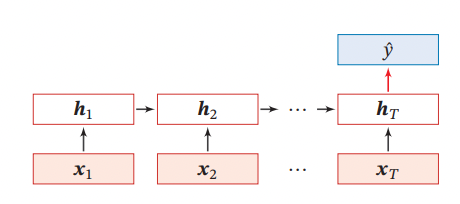

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import numpy as np
from tqdm import tqdm
import random

def preprocess_data(X, Y):
    max_length = max(len(seq) for seq in X)
    vector_dim = len(X[0][0])
    X_padded = torch.zeros((len(X), max_length, vector_dim))
    for i, seq in enumerate(X):
        seq_array = np.array(seq)
        seq_length = seq_array.shape[0]
        X_padded[i, :seq_length, :] = torch.from_numpy(seq_array)
    Y_tensor = torch.tensor(Y, dtype=torch.float)
    return X_padded, Y_tensor

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.U = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W = nn.Linear(input_size, hidden_size, bias=False)
        self.b = nn.Parameter(torch.zeros(hidden_size))
        self.V = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        batch_size, sequence_length, _ = x.size()
        h_t = self.init_hidden(batch_size).to(x.device)  # h0
        for t in range(sequence_length):
            x_t = x[:, t, :]
            h_t = self.relu(self.U(h_t) + self.W(x_t) + self.b) # h_t: (batch_size, hidden_size)
        y_T = self.sigmoid(self.V(h_t))
        return y_T, h_t                                         # y_T: (batch_size, output_size)

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

input_size = X_train[0][0].shape[0]
hidden_size = 128
output_size = 1
rnn = SimpleRNN(input_size, hidden_size, output_size)
print(rnn)

SimpleRNN(
  (U): Linear(in_features=128, out_features=128, bias=False)
  (W): Linear(in_features=300, out_features=128, bias=False)
  (V): Linear(in_features=128, out_features=1, bias=True)
  (tanh): Tanh()
  (sigmoid): Sigmoid()
  (relu): LeakyReLU(negative_slope=0.01)
)


## LSTM

In LSTM, internal state $\textbf{c}_t$ is introduced and used in LSTM along with hidden state $\textbf{h}_t$.
$$
\begin{aligned}
\textbf{c}_t&=\textbf{f}_t\odot\textbf{c}_{t-1}+\textbf{i}_t\odot\tilde{\textbf{c}}_t\\
\textbf{h}_t&=\textbf{o}_t\odot\textbf{tanh}(\textbf{c}_t)
\end{aligned}
$$
where $\textbf{f}_t$, $\textbf{i}_t$, $\textbf{o}_t$ are forget, input and output gates respectively.
$$
\begin{aligned}
\textbf{f}_t&=\sigma(\textbf{W}_f\textbf{h}_{t-1}+\textbf{U}_f\textbf{x}_t+\textbf{b}_f)\\
\textbf{i}_t&=\sigma(\textbf{W}_i\textbf{h}_{t-1}+\textbf{U}_i\textbf{x}_t+\textbf{b}_i)\\
\textbf{o}_t&=\sigma(\textbf{W}_o\textbf{h}_{t-1}+\textbf{U}_o\textbf{x}_t+\textbf{b}_o)\\
\end{aligned}
$$
and $\tilde{\textbf{c}_t}$ is the candidate state.
$$
\tilde{\textbf{c}}_t=\textbf{tanh}(\textbf{W}_c\textbf{h}_{t-1}+\textbf{U}_c\textbf{x}_t+\textbf{b}_c)
$$

For the computation above, $\sigma(\cdot)$ is the sigmoid function and $\odot$ is the element-wise multiplication. 

Intuitively, $\textbf{f}_t$ decides how much of the previous state to forget, $\textbf{i}_t$ decides how much of the candidate state to remember and $\textbf{o}_t$ decides how much of the internal state to output.

In fact, we can adopt a much simpler structure to compute the gates and candidate state.
$$
\begin{aligned}
\begin{bmatrix}
\tilde{\textbf{c}}_t\\
\textbf{o}_t\\
\textbf{i}_t\\
\textbf{f}_t
\end{bmatrix}=\begin{bmatrix}
\text{tanh}\\
\sigma\\
\sigma\\
\sigma
\end{bmatrix}
\left(\textbf{W}\begin{bmatrix}
\textbf{x}_{t}\\
\textbf{h}_{t-1}
\end{bmatrix}+\textbf{b}\right)
\end{aligned}
$$
So we only need to concatenate $\textbf{x}_t$ and $\textbf{h}_{t-1}$ into a big matrix, multiply with a single weight matrix $\textbf{W}$ and run it through activations to get the gates and candidate state.




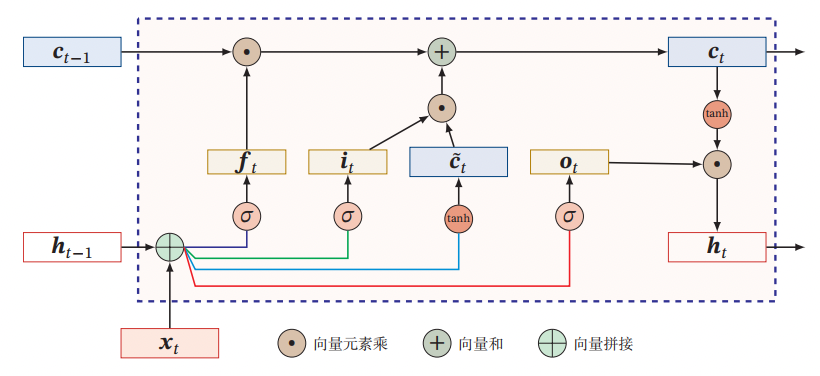

In [114]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.f = nn.Linear(input_size + hidden_size, hidden_size)
        self.i = nn.Linear(input_size + hidden_size, hidden_size)
        self.o = nn.Linear(input_size + hidden_size, hidden_size)
        self.c = nn.Linear(input_size + hidden_size, hidden_size)

        self.output = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.LeakyReLU()

    def forward(self, x, init_states=None):
        # x shape: (batch_size, sequence_length, input_size)
        batch_size, seq_len, _ = x.size()
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
            c_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        else:
            h_t, c_t = init_states
        
        hidden_seq = []
        for t in range(seq_len):
            x_t = x[:, t, :]
            combined = torch.cat((x_t, h_t), dim=1)
            f_t = self.sigmoid(self.f(combined))
            i_t = self.sigmoid(self.i(combined))
            o_t = self.sigmoid(self.o(combined))
            tilde_c_t = self.tanh(self.c(combined))
            c_t = f_t * c_t + i_t * tilde_c_t                      # c_t: (batch_size, hidden_size)
            h_t = o_t * self.tanh(c_t)                             # h_t: (batch_size, hidden_size)

            hidden_seq.append(h_t.unsqueeze(0))                    # h_t.unsqueeze(0): (1, batch_size, hidden_size)
            
        hidden_seq = torch.cat(hidden_seq, dim=0)                  # hidden_seq: (seq_len, batch_size, hidden_size)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()       # hidden_seq: (batch_size, seq_len, hidden_size)

        ave_h_T = torch.mean(hidden_seq, dim=1)                    # ave_y_T: (batch_size, hidden_size)
        h_T = hidden_seq[:, -1, :]                                 # h_T: (batch_size, hidden_size)
        y_T = self.sigmoid(self.output(h_T))

        return y_T, (h_t, c_t)                                     # y_T: (batch_size, output_size)

input_size = X_train[0][0].shape[0]
hidden_size = 128
output_size = 1
lstm = LSTM(input_size, hidden_size, output_size)
print(lstm)

LSTM(
  (f): Linear(in_features=428, out_features=128, bias=True)
  (i): Linear(in_features=428, out_features=128, bias=True)
  (o): Linear(in_features=428, out_features=128, bias=True)
  (c): Linear(in_features=428, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=1, bias=True)
  (tanh): Tanh()
  (sigmoid): Sigmoid()
  (relu): LeakyReLU(negative_slope=0.01)
)


## Early Stopping Mechanism

In [11]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience    # how long to wait after last time validation loss improved
        self.verbose = verbose      # print the message if True
        self.counter = 0            # counting epochs that do not improve the model
        self.best_score = None      # the best score so far
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta          # minimum change in the monitored quantity to qualify as an improvement
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss           # high val_loss -> low score
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [12]:
class WeightedBCELoss(nn.Module):
    def __init__(self, spam_weight=10.0):
        super(WeightedBCELoss, self).__init__()
        self.spam_weight = spam_weight
        self.bce_loss = nn.BCELoss(reduction='none')

    def forward(self, predictions, targets):
        bce_loss = self.bce_loss(predictions, targets)
        weights = torch.ones_like(targets)
        weights[targets == 1] = self.spam_weight
        weighted_loss = bce_loss * weights
        return weighted_loss.mean()

# Training and Evaluation

In [14]:
from torch.utils.tensorboard import SummaryWriter
import os

def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.determinstic = True

def train(model, train_loader, criterion, optimizer, device, epoch, writer):
    model.train()
    total_loss = 0
    train_iter = tqdm(train_loader, desc=f"Epoch {epoch} Training", leave=False)
    for i, (batch_x, batch_y) in enumerate(train_iter):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output, _ = model(batch_x)
        loss = criterion(output.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predicted = (output.squeeze() > 0.5).float()
        accuracy = (predicted == batch_y).sum().item() / batch_y.size(0)
        train_iter.set_postfix({'loss': f"{loss.item():.4f}", 'accuracy': f"{accuracy:.4f}"})
        writer.add_scalar('Loss/train', loss.item(), epoch * len(train_loader) + i)
    accuracy = (predicted == batch_y).sum().item() / batch_y.size(0)
    avg_loss = total_loss / len(train_loader)
    return avg_loss, accuracy

def evaluate(model, test_loader, criterion, device, epoch, writer):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    eval_iter = tqdm(test_loader, desc=f"Epoch {epoch} Evaluating", leave=False)
    with torch.no_grad():
        for i, (batch_x, batch_y) in enumerate(eval_iter):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output, _ = model(batch_x)
            loss = criterion(output.squeeze(), batch_y)
            total_loss += loss.item()
            predicted = (output.squeeze() > 0.5).float()
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            accuracy = correct / total
            eval_iter.set_postfix({'loss': f"{loss.item():.4f}", 'accuracy': f"{accuracy:.4f}"})
            writer.add_scalar('Loss/val', loss.item(), epoch * len(test_loader) + i)
    accuracy = correct / total
    avg_loss = total_loss / len(test_loader)
    return avg_loss, accuracy

# Dataloader

In [15]:
set_random_seed(114514)

X_train_tensor, Y_train_tensor = preprocess_data(X_train, Y_train)
X_test_tensor, Y_test_tensor = preprocess_data(X_test, Y_test)

# dataloader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [62]:
"""def create_balanced_dataloader(dataset, batch_size, shuffle=True):
    # The dataset is inbalanced with 4854 ham and 749 spam
    # We need a balanced dataloader to train the model
    labels = [int(label) for _, label in dataset]
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])

    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in labels])
    samples_weight = torch.from_numpy(samples_weight)

    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=sampler if shuffle else None,
        shuffle=shuffle if sampler is None else False
    )
    
    return loader

train_loader = create_balanced_dataloader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = create_balanced_dataloader(test_dataset, batch_size=batch_size, shuffle=True)

"""

Train loader balance:
Ham: 2346, Spam: 2384
Test loader balance:
Ham: 408, Spam: 427


In [16]:
def check_balance(loader):
    ham_count = 0
    spam_count = 0
    for _, labels in loader:
        ham_count += (labels == 0).sum().item()
        spam_count += (labels == 1).sum().item()
    print(f"Ham: {ham_count}, Spam: {spam_count}")

print("Train loader balance:")
check_balance(train_loader)

print("Test loader balance:")
check_balance(test_loader)

Train loader balance:
Ham: 4098, Spam: 632
Test loader balance:
Ham: 721, Spam: 114


# Training SimpleRNN

In [44]:
# hyperparameters
input_size = X_train_tensor.size(2)  # 300, in this case
hidden_size = 128
output_size = 1

# initialize the model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleRNN(input_size, hidden_size, output_size).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

# tensorboard
log_dir = 'runs/hw2_experiment'
writer = SummaryWriter(log_dir)

# earlystopping
early_stopping = EarlyStopping(patience=10, verbose=True, path='checkpoint_rnn.pt')

num_epochs = 50
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device, epoch+1, writer)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device, epoch+1, writer)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {test_loss:.4f}, Val Accuracy: {test_accuracy:.4f}")
    early_stopping(test_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
writer.close()

Epoch 1/50, Train Loss: 0.6836, Train Accuracy: 0.8448, Val Loss: 0.6828, Val Accuracy: 0.8635
Validation loss decreased (inf --> 0.682787). Saving model ...


Epoch 2/50, Train Loss: 0.6824, Train Accuracy: 0.8793, Val Loss: 0.6814, Val Accuracy: 0.8635
Validation loss decreased (0.682787 --> 0.681436). Saving model ...


Epoch 3/50, Train Loss: 0.6809, Train Accuracy: 0.8793, Val Loss: 0.6797, Val Accuracy: 0.8635
Validation loss decreased (0.681436 --> 0.679709). Saving model ...


Epoch 4/50, Train Loss: 0.6789, Train Accuracy: 0.7931, Val Loss: 0.6774, Val Accuracy: 0.8635
Validation loss decreased (0.679709 --> 0.677352). Saving model ...


Epoch 5/50, Train Loss: 0.6761, Train Accuracy: 0.9138, Val Loss: 0.6738, Val Accuracy: 0.8635
Validation loss decreased (0.677352 --> 0.673834). Saving model ...


Epoch 6/50, Train Loss: 0.6714, Train Accuracy: 0.9310, Val Loss: 0.6688, Val Accuracy: 0.8635
Validation loss decreased (0.673834 --> 0.668786). Saving model ...


Epoch 7/50, Train Loss: 0.6603, Train Accuracy: 0.8793, Val Loss: 0.6471, Val Accuracy: 0.8635
Validation loss decreased (0.668786 --> 0.647084). Saving model ...


Epoch 8/50, Train Loss: 0.5535, Train Accuracy: 0.8621, Val Loss: 0.4477, Val Accuracy: 0.8635
Validation loss decreased (0.647084 --> 0.447708). Saving model ...


Epoch 9/50, Train Loss: 0.3923, Train Accuracy: 0.8621, Val Loss: 0.4074, Val Accuracy: 0.8635
Validation loss decreased (0.447708 --> 0.407436). Saving model ...


Epoch 10/50, Train Loss: 0.3861, Train Accuracy: 0.9138, Val Loss: 0.4325, Val Accuracy: 0.8635
EarlyStopping counter: 1 out of 10


Epoch 11/50, Train Loss: 0.3808, Train Accuracy: 0.8276, Val Loss: 0.3921, Val Accuracy: 0.8635
Validation loss decreased (0.407436 --> 0.392126). Saving model ...


Epoch 12/50, Train Loss: 0.3753, Train Accuracy: 0.8448, Val Loss: 0.3508, Val Accuracy: 0.8635
Validation loss decreased (0.392126 --> 0.350831). Saving model ...


Epoch 13/50, Train Loss: 0.3681, Train Accuracy: 0.8448, Val Loss: 0.3473, Val Accuracy: 0.8635
Validation loss decreased (0.350831 --> 0.347279). Saving model ...


Epoch 14/50, Train Loss: 0.3591, Train Accuracy: 0.8966, Val Loss: 0.3318, Val Accuracy: 0.8635
Validation loss decreased (0.347279 --> 0.331835). Saving model ...


Epoch 15/50, Train Loss: 0.3458, Train Accuracy: 0.8966, Val Loss: 0.3357, Val Accuracy: 0.8635
EarlyStopping counter: 1 out of 10


Epoch 16/50, Train Loss: 0.3265, Train Accuracy: 0.9138, Val Loss: 0.3381, Val Accuracy: 0.8635
EarlyStopping counter: 2 out of 10


Epoch 17/50, Train Loss: 0.2538, Train Accuracy: 0.7759, Val Loss: 0.2789, Val Accuracy: 0.8635
Validation loss decreased (0.331835 --> 0.278901). Saving model ...


Epoch 18/50, Train Loss: 0.1936, Train Accuracy: 0.8448, Val Loss: 0.3271, Val Accuracy: 0.8635
EarlyStopping counter: 1 out of 10


Epoch 19/50, Train Loss: 0.1903, Train Accuracy: 0.8448, Val Loss: 0.3518, Val Accuracy: 0.8635
EarlyStopping counter: 2 out of 10


Epoch 20/50, Train Loss: 0.1885, Train Accuracy: 0.9483, Val Loss: 0.3209, Val Accuracy: 0.8635
EarlyStopping counter: 3 out of 10


Epoch 21/50, Train Loss: 0.1861, Train Accuracy: 0.8966, Val Loss: 0.3366, Val Accuracy: 0.8635
EarlyStopping counter: 4 out of 10


Epoch 22/50, Train Loss: 0.1858, Train Accuracy: 0.8448, Val Loss: 0.3328, Val Accuracy: 0.8635
EarlyStopping counter: 5 out of 10


Epoch 23/50, Train Loss: 0.2029, Train Accuracy: 0.9310, Val Loss: 0.3419, Val Accuracy: 0.8635
EarlyStopping counter: 6 out of 10


Epoch 24/50, Train Loss: 0.1913, Train Accuracy: 0.9655, Val Loss: 0.3667, Val Accuracy: 0.8635
EarlyStopping counter: 7 out of 10


Epoch 25/50, Train Loss: 0.1865, Train Accuracy: 0.8448, Val Loss: 0.3076, Val Accuracy: 0.8635
EarlyStopping counter: 8 out of 10


Epoch 26/50, Train Loss: 0.1894, Train Accuracy: 0.9138, Val Loss: 0.3097, Val Accuracy: 0.8635
EarlyStopping counter: 9 out of 10


Epoch 27/50, Train Loss: 0.1870, Train Accuracy: 0.8621, Val Loss: 0.3296, Val Accuracy: 0.8635
EarlyStopping counter: 10 out of 10


Epoch 28/50, Train Loss: 0.1748, Train Accuracy: 0.7931, Val Loss: 0.3302, Val Accuracy: 0.8635
EarlyStopping counter: 11 out of 10


Epoch 29/50, Train Loss: 0.1766, Train Accuracy: 0.8621, Val Loss: 0.3441, Val Accuracy: 0.8635
EarlyStopping counter: 12 out of 10


Epoch 30/50, Train Loss: 0.1864, Train Accuracy: 0.9138, Val Loss: 0.3275, Val Accuracy: 0.8635
EarlyStopping counter: 13 out of 10


Epoch 31/50, Train Loss: 0.1847, Train Accuracy: 0.8448, Val Loss: 0.3175, Val Accuracy: 0.8635
EarlyStopping counter: 14 out of 10


Epoch 32/50, Train Loss: 0.1839, Train Accuracy: 0.8621, Val Loss: 0.3453, Val Accuracy: 0.8635
EarlyStopping counter: 15 out of 10


Epoch 33/50, Train Loss: 0.1851, Train Accuracy: 0.8966, Val Loss: 0.3178, Val Accuracy: 0.8635
EarlyStopping counter: 16 out of 10


Epoch 34/50, Train Loss: 0.1840, Train Accuracy: 0.9138, Val Loss: 0.3533, Val Accuracy: 0.8635
EarlyStopping counter: 17 out of 10


Epoch 35/50, Train Loss: 0.1853, Train Accuracy: 0.8966, Val Loss: 0.3393, Val Accuracy: 0.8635
EarlyStopping counter: 18 out of 10


Epoch 36/50, Train Loss: 0.1820, Train Accuracy: 0.8793, Val Loss: 0.3100, Val Accuracy: 0.8635
EarlyStopping counter: 19 out of 10


Epoch 37/50, Train Loss: 0.1778, Train Accuracy: 0.8621, Val Loss: 0.3086, Val Accuracy: 0.8635
EarlyStopping counter: 20 out of 10


Epoch 38/50, Train Loss: 0.1772, Train Accuracy: 0.8793, Val Loss: 0.3172, Val Accuracy: 0.8958
EarlyStopping counter: 21 out of 10


Epoch 39/50, Train Loss: 0.1765, Train Accuracy: 0.9483, Val Loss: 0.3214, Val Accuracy: 0.8958
EarlyStopping counter: 22 out of 10


Epoch 40/50, Train Loss: 0.1771, Train Accuracy: 0.9138, Val Loss: 0.3067, Val Accuracy: 0.8994
EarlyStopping counter: 23 out of 10


Epoch 41/50, Train Loss: 0.1756, Train Accuracy: 0.9655, Val Loss: 0.3296, Val Accuracy: 0.8958
EarlyStopping counter: 24 out of 10


Epoch 42/50, Train Loss: 0.1785, Train Accuracy: 0.8966, Val Loss: 0.3081, Val Accuracy: 0.8970
EarlyStopping counter: 25 out of 10


Epoch 43/50, Train Loss: 0.1795, Train Accuracy: 0.8621, Val Loss: 0.3222, Val Accuracy: 0.8910
EarlyStopping counter: 26 out of 10


Epoch 44/50, Train Loss: 0.1836, Train Accuracy: 0.9138, Val Loss: 0.3271, Val Accuracy: 0.8958
EarlyStopping counter: 27 out of 10


Epoch 45/50, Train Loss: 0.1736, Train Accuracy: 0.8276, Val Loss: 0.2980, Val Accuracy: 0.8635
EarlyStopping counter: 28 out of 10


Epoch 46/50, Train Loss: 0.1602, Train Accuracy: 0.8621, Val Loss: 0.3069, Val Accuracy: 0.8635
EarlyStopping counter: 29 out of 10


Epoch 47/50, Train Loss: 0.1596, Train Accuracy: 0.8448, Val Loss: 0.3031, Val Accuracy: 0.8635
EarlyStopping counter: 30 out of 10


Epoch 48/50, Train Loss: 0.1599, Train Accuracy: 0.9310, Val Loss: 0.3007, Val Accuracy: 0.8635
EarlyStopping counter: 31 out of 10


Epoch 49/50, Train Loss: 0.1594, Train Accuracy: 0.8103, Val Loss: 0.3152, Val Accuracy: 0.8635
EarlyStopping counter: 32 out of 10


Epoch 50/50, Train Loss: 0.1587, Train Accuracy: 0.9483, Val Loss: 0.3008, Val Accuracy: 0.9497
EarlyStopping counter: 33 out of 10


# Training LSTM

In [115]:
# hyperparameters
input_size = X_train_tensor.size(2)  # 300, in this case
hidden_size = 128
output_size = 1

# initialize the model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = LSTM(input_size, hidden_size, output_size).to(device)     # use embedded LSTM

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

# tensorboard
log_dir = 'runs/hw2_experiment'
writer = SummaryWriter(log_dir)

# earlystopping
early_stopping2 = EarlyStopping(patience=10, verbose=True, path='checkpoint_lstm.pt')

num_epochs = 50
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model2, train_loader, criterion, optimizer, device, epoch+1, writer)
    test_loss, test_accuracy = evaluate(model2, test_loader, criterion, device, epoch+1, writer)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {test_loss:.4f}, Val Accuracy: {test_accuracy:.4f}")
    early_stopping2(test_loss, model2)
    if early_stopping2.early_stop:
        print("Early stopping")
        break
    
writer.close()

Epoch 1 Training:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch 1/50, Train Loss: 0.6690, Train Accuracy: 0.7931, Val Loss: 0.6716, Val Accuracy: 0.8635
Validation loss decreased (inf --> 0.671648). Saving model ...


Epoch 2/50, Train Loss: 0.6690, Train Accuracy: 0.8276, Val Loss: 0.6701, Val Accuracy: 0.8635
Validation loss decreased (0.671648 --> 0.670119). Saving model ...


Epoch 3/50, Train Loss: 0.6690, Train Accuracy: 0.8793, Val Loss: 0.6686, Val Accuracy: 0.8635
Validation loss decreased (0.670119 --> 0.668590). Saving model ...


Epoch 4/50, Train Loss: 0.6690, Train Accuracy: 0.9138, Val Loss: 0.6686, Val Accuracy: 0.8635
Validation loss decreased (0.668590 --> 0.668590). Saving model ...


Epoch 5/50, Train Loss: 0.6690, Train Accuracy: 0.8793, Val Loss: 0.6686, Val Accuracy: 0.8635
EarlyStopping counter: 1 out of 10


Epoch 6/50, Train Loss: 0.6690, Train Accuracy: 0.8966, Val Loss: 0.6701, Val Accuracy: 0.8635
EarlyStopping counter: 2 out of 10


Epoch 7/50, Train Loss: 0.6690, Train Accuracy: 0.8621, Val Loss: 0.6686, Val Accuracy: 0.8635
Validation loss decreased (0.668590 --> 0.668590). Saving model ...


Epoch 8/50, Train Loss: 0.6690, Train Accuracy: 0.8276, Val Loss: 0.6701, Val Accuracy: 0.8635
EarlyStopping counter: 1 out of 10


Epoch 9/50, Train Loss: 0.6690, Train Accuracy: 0.8793, Val Loss: 0.6701, Val Accuracy: 0.8635
EarlyStopping counter: 2 out of 10


Epoch 10/50, Train Loss: 0.6690, Train Accuracy: 0.8966, Val Loss: 0.6686, Val Accuracy: 0.8635
EarlyStopping counter: 3 out of 10


Epoch 11/50, Train Loss: 0.6690, Train Accuracy: 0.9310, Val Loss: 0.6701, Val Accuracy: 0.8635
EarlyStopping counter: 4 out of 10


Epoch 12/50, Train Loss: 0.6690, Train Accuracy: 0.8793, Val Loss: 0.6686, Val Accuracy: 0.8635
EarlyStopping counter: 5 out of 10


Epoch 13/50, Train Loss: 0.6690, Train Accuracy: 0.8103, Val Loss: 0.6701, Val Accuracy: 0.8635
EarlyStopping counter: 6 out of 10


Epoch 14/50, Train Loss: 0.6690, Train Accuracy: 0.8966, Val Loss: 0.6716, Val Accuracy: 0.8635
EarlyStopping counter: 7 out of 10


Epoch 15/50, Train Loss: 0.6690, Train Accuracy: 0.8621, Val Loss: 0.6686, Val Accuracy: 0.8635
EarlyStopping counter: 8 out of 10


Epoch 16/50, Train Loss: 0.6690, Train Accuracy: 0.8276, Val Loss: 0.6686, Val Accuracy: 0.8635
EarlyStopping counter: 9 out of 10


Epoch 17/50, Train Loss: 0.6690, Train Accuracy: 0.7931, Val Loss: 0.6701, Val Accuracy: 0.8635
EarlyStopping counter: 10 out of 10
Early stopping


# Use the model

## Use SimpleRNN

In [45]:
# load the best model from the checkpoint
input_size = X_train_tensor.size(2)  # 300, in this case
hidden_size = 128
output_size = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleRNN(input_size, hidden_size, output_size)
model.load_state_dict(torch.load('checkpoint_rnn.pt', map_location=device))
model.to('cpu')
model.eval()
# check if the message is a spam
# List to store spam probabilities or "Invalid"
spam_probabilities = []
predictions = []
done = 0

# Iterate through each email and get the spam probability or mark as "Invalid"
for email in df.v2:
    if pre_processing(email, tokenizer, word2vec_model) is not None:
        email_array = np.array(pre_processing(email, tokenizer, word2vec_model))
        email_tensor = torch.from_numpy(email_array).unsqueeze(0)
        output, _ = model(email_tensor)
        predictions.append('spam') if output.item() > 0.5 else predictions.append('ham')  # Add prediction
        spam_probabilities.append(output.item())  # Add spam probability
    else:
        spam_probabilities.append("Invalid")  # Mark as "Invalid"
        predictions.append("Invalid")
    done += 1

print(f"Processed emails: {done}")
print(f"Length of spam_probabilities: {len(spam_probabilities)}")

# Write the updated DataFrame (including the true labels) to a CSV file
spam_df = pd.DataFrame({'email': df.v2, 'spam_probability': spam_probabilities, 'predicted_label': predictions, 'true_label': df.v1})
spam_df.to_csv('spam_probability_simple_rnn.csv', index=False, columns=['email', 'spam_probability', 'predicted_label', 'true_label'])

/var/folders/wz/4cyv558d01jb0_wb8_71vmz00000gn/T/ipykernel_45590/4004077628.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint_

No embeddings found for sentence: beerage 
No embeddings found for sentence:  
No embeddings found for sentence: alrite
No embeddings found for sentence:  
No embeddings found for sentence: ringtoneking 
No embeddings found for sentence: erutupalam thandiyachu
No embeddings found for sentence:  
Processed emails: 5572
Length of spam_probabilities: 5572


In [57]:
try_email = "Tsinghua University has admitted you, please click the link to claim your scholarship"
email_array = np.array(pre_processing(try_email, tokenizer, word2vec_model))
email_tensor = torch.from_numpy(email_array).unsqueeze(0)
output, _ = model(email_tensor)
print(f"Spam probability: {output.item()}")

Spam probability: 0.5987138748168945


## Use LSTM

In [116]:
# load the best model from the checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = LSTM(input_size, hidden_size, output_size)
model2.load_state_dict(torch.load('checkpoint_lstm.pt', map_location=device))
model2.to('cpu')
model2.eval()
# check if the message is a spam
spam_probabilities = []
predictions = []
done = 0

# Iterate through each email and get the spam probability or mark as "Invalid"
for email in df.v2:
    if pre_processing(email, tokenizer, word2vec_model) is not None:
        email_array = np.array(pre_processing(email, tokenizer, word2vec_model))
        email_tensor = torch.from_numpy(email_array).unsqueeze(0)
        output, _ = model2(email_tensor)
        predictions.append('spam') if output.item() > 0.5 else predictions.append('ham')  # Add prediction
        spam_probabilities.append(output.item())  # Add spam probability
    else:
        spam_probabilities.append("Invalid")  # Mark as "Invalid"
        predictions.append("Invalid")
    done += 1

print(f"Processed emails: {done}")
print(f"Length of spam_probabilities: {len(spam_probabilities)}")

# Write the updated DataFrame (including the true labels) to a CSV file
spam_df = pd.DataFrame({'email': df.v2, 'spam_probability': spam_probabilities, 'predicted_label': predictions, 'true_label': df.v1})
spam_df.to_csv('spam_probability_lstm.csv', index=False, columns=['email', 'spam_probability', 'predicted_label', 'true_label'])

/var/folders/wz/4cyv558d01jb0_wb8_71vmz00000gn/T/ipykernel_45590/99970866.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('checkpoint_l

No embeddings found for sentence: beerage 
No embeddings found for sentence:  
No embeddings found for sentence: alrite
No embeddings found for sentence:  
No embeddings found for sentence: ringtoneking 
No embeddings found for sentence: erutupalam thandiyachu
No embeddings found for sentence:  
Processed emails: 5572
Length of spam_probabilities: 5572


In [117]:
try_email = "Bingo! You have won a free trip to Hawaii"
email_array = np.array(pre_processing(try_email, tokenizer, word2vec_model))
email_tensor = torch.from_numpy(email_array).unsqueeze(0)
output, _ = model2(email_tensor)
print(f"Spam probability: {output.item()}")

Spam probability: 0.48114117980003357
